# Trabalho prático 2 - Classificação

### Davi Segundo - 417153 & Diego Holanda - 411627



## Bibliotecas e módulos utilizados no trabalho

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_precision_recall_curve

## Dataset

link para o dataset: [Obesity Dataset](https://archive.ics.uci.edu/ml/datasets/Estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition+)

### Descrição
The attributes related with eating habits are: Frequent consumption of high caloric food (FAVC), Frequency of consumption of vegetables (FCVC), Number of main meals (NCP), Consumption of food between meals (CAEC), Consumption of water daily (CH20), and Consumption of alcohol (CALC). The attributes related with the physical condition are: Calories consumption monitoring (SCC), Physical activity frequency (FAF), Time using technology devices (TUE), Transportation used (MTRANS), other variables obtained were: Gender, Age, Height and Weight. Finally, all data was labeled and the class variable NObesity was created with the values of: Insufficient Weight, Normal Weight, Overweight Level I, Overweight Level II, Obesity Type I, Obesity Type II and Obesity Type III, based on Equation (1) and information from WHO and Mexican Normativity. The data contains numerical data and continous data, so it can be used for analysis based on algorithms of classification, prediction, segmentation and association. Data is available in CSV format and ARFF format to be used with the Weka too

### Funções auxiliares

In [2]:
def show_metrics(results):
    accuracy = results["test_accuracy"].mean()
    recall = results["test_recall_macro"].mean()
    precision = results["test_precision_macro"].mean()
    print("----------------------")
    print(f"Accuracy_Mean:  {accuracy*100:.2f}%")
    print(f"Recall_Mean:    {recall*100:.2f}%")
    print(f"Precision_Mean: {precision*100:.2f}%")

### Configuração de plot dos gráficos

In [3]:
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15

## Leitura e preparação dos dados

In [4]:
raw_data = pd.read_csv('./datasets/ObesityDataSet_raw_and_data_sinthetic.csv')
raw_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Transformação dos dados categóricos

In [5]:
category_consumption = ['no', 
                        'Sometimes', 
                        'Frequently', 
                        'Always'] 

category_transport = ['Automobile', 
                      'Motorbike', 
                      'Public_Transportation', 
                      'Bike', 'Walking']

obesity_level_encoder = LabelEncoder()

In [6]:
ordinal_encoder = make_column_transformer(
    (OrdinalEncoder(), ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']),
    (OrdinalEncoder(categories=[category_consumption, category_consumption]), ['CALC', 'CAEC']),
    (OrdinalEncoder(categories=[category_transport]), ['MTRANS']),
    remainder='passthrough'
)

### Separação do conjunto de treino e teste

In [7]:
train_set, test_set = train_test_split(raw_data, test_size=.2, random_state=42)

In [8]:
x_train = train_set.iloc[:, :-1]
y_train = obesity_level_encoder.fit_transform(train_set.NObeyesdad)

x_test = test_set.iloc[:, :-1]
y_test = obesity_level_encoder.transform(test_set.NObeyesdad)

## Paramêtros de otimização do GridSearch

In [9]:
logistic_parameters = {
    'model__penalty' : ['l2', 'none'],
    'model__multi_class' : ['ovr', 'multinomial'],
    'model__max_iter' : [500],
    'model__solver' : ['newton-cg']
}

tree_parameters = {
    'model__max_depth': [2,4,6,8,10,12],
    'model__criterion': ['gini', 'entropy']
}

knn_parameters = {
    'model__n_neighbors': [3, 5, 7, 8, 11],
    'model__weights' : ['uniform', 'distance'],
    'model__metric' : ['manhattan', 'euclidean', 'minkowski']
}

svc_parameters = {
    'model__C': [0.1, 1, 10, 100], 
    'model__gamma': [1, 0.1, 0.01, 0.001],
    'model__kernel': ['rbf', 'poly', 'sigmoid']
}

## Regressão Logística

Regressão Logística é um modelo que usa a função sigmóide para mapear os dados de entrada para valores entre 0 e 1, o que possibilita modelar a probabilidade de uma certa entrada $x$ pertencer a uma classe $K$ como uma distribuição de Bernoulli. Esse modelo foi originalmente desenvolvido para casos de classificação binária, porém podemos a estratégia de `one vs all` para modelar casos multiclasse.

A parte mais interessante é que apesar de ser usado para a regressão, os algoritmos de GD e SGD também podem ser usados para encontrar os pesos ótimos de forma iterativa.

In [10]:
model = LogisticRegression()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = logistic_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_iter,param_model__multi_class,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,9.729653,4.563237,0.012341,0.003488,500,multinomial,none,newton-cg,"{'model__max_iter': 500, 'model__multi_class':...",0.949704,0.946746,0.920118,0.940653,0.964392,0.944323,0.014401,1
2,0.160688,0.026582,0.009127,0.000745,500,multinomial,l2,newton-cg,"{'model__max_iter': 500, 'model__multi_class':...",0.872781,0.872781,0.857988,0.839763,0.863501,0.861363,0.012192,2
1,0.848850,0.098177,0.020270,0.009336,500,ovr,none,newton-cg,"{'model__max_iter': 500, 'model__multi_class':...",0.766272,0.772189,0.754438,0.768546,0.798220,0.771933,0.014427,3
0,0.730841,0.135554,0.021294,0.004683,500,ovr,l2,newton-cg,"{'model__max_iter': 500, 'model__multi_class':...",0.745562,0.757396,0.739645,0.738872,0.756677,0.747631,0.008024,4


In [11]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  90.31%
Recall_Mean:    90.17%
Precision_Mean: 90.45%


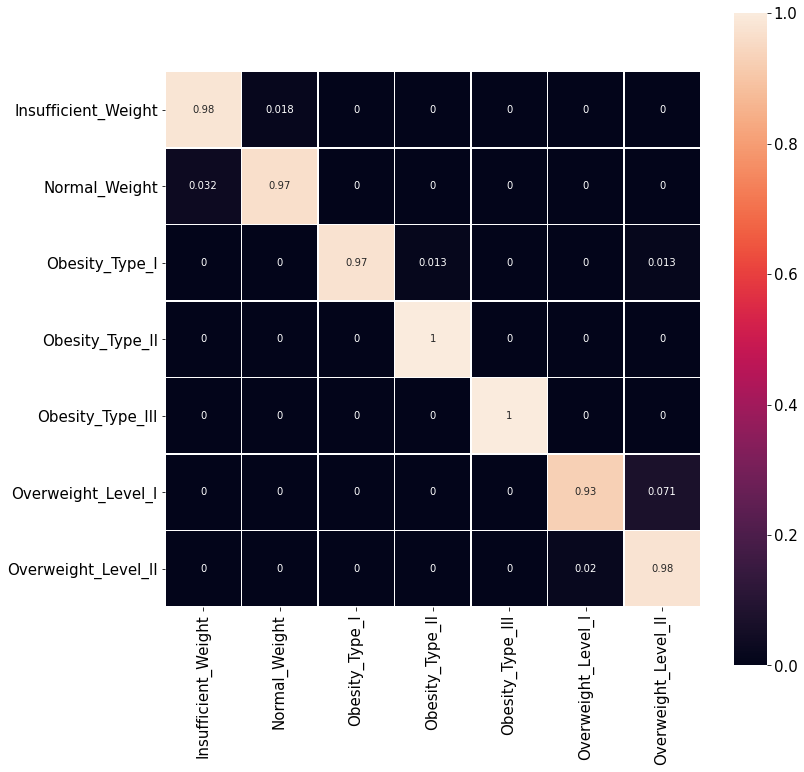

In [12]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## Árvore de Decisão

Árvores de decisão se baseiam na ideia de nós podermos dividir nossos espaços de decisão por meio de premissas lógicas `se...então..`, essa divisão é então codificada em formato de árvore de forma que as folhas representam a classe (ou valor no caso da regressão) predito e os nós internos representam as regras lógicas aplicadas sobre um atributo específico.

### Como construir a árvore a partir dos atributos?
Calcular a árvore ótima (menor profundidade) é um problema NP-difícil, o que seria inviável para algoritmos de treinamento. Sendo assim, árvores de decisão se baseiam em uma heurística gulosa sobre `índices de pureza`, ou seja, encontramos tentamos encontrar o atributo que melhor divide o espaço naquele momento.

### O que são índices de pureza?
Índices de pureza são uma forma de mensurar quão consistente é a nossa divisão, no caso quanto maior o nosso índice de pureza melhor, visto que o nosso espaço possui vários elementos do mesmo tipo, ou seja, é mais consistente.

A árvore de decisão do `sklearn` possui dois possíveis critérios para o índice de pureza: `gini` e `entropy`.

### Overfitting
É importante ficar atento à profundidade da nossa árvore, visto que, desconsiderando o ruído podemos dividir nosso espaço de decisão de maneira arbitrariamente pequena, o que prejudica a generalização do modelo criando divisões extremamente específicas.

Podemos usar grid search sobre a profundidade máxima da árvore para encontrar um tamanho que generalize bem os dados sem causar overfitting.

In [13]:
model = DecisionTreeClassifier()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = tree_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__criterion,param_model__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.044183,0.005355,0.013193,0.003176,entropy,10,"{'model__criterion': 'entropy', 'model__max_de...",0.928994,0.964497,0.934911,0.940653,0.958457,0.945502,0.013688,1
11,0.034571,0.002623,0.009218,0.001061,entropy,12,"{'model__criterion': 'entropy', 'model__max_de...",0.937870,0.961538,0.943787,0.940653,0.937685,0.944307,0.008898,2
9,0.037337,0.004097,0.010810,0.001159,entropy,8,"{'model__criterion': 'entropy', 'model__max_de...",0.926036,0.952663,0.949704,0.940653,0.949555,0.943722,0.009716,3
5,0.029906,0.012011,0.012324,0.006110,gini,12,"{'model__criterion': 'gini', 'model__max_depth...",0.926036,0.923077,0.926036,0.928783,0.940653,0.928917,0.006139,4
4,0.024764,0.003136,0.009187,0.001469,gini,10,"{'model__criterion': 'gini', 'model__max_depth...",0.928994,0.928994,0.923077,0.925816,0.910979,0.923572,0.006673,5
3,0.027405,0.004366,0.010873,0.001181,gini,8,"{'model__criterion': 'gini', 'model__max_depth...",0.914201,0.914201,0.923077,0.919881,0.902077,0.914688,0.007167,6
2,0.026304,0.001430,0.010398,0.001628,gini,6,"{'model__criterion': 'gini', 'model__max_depth...",0.866864,0.881657,0.928994,0.872404,0.908012,0.891586,0.023439,7
8,0.035834,0.005271,0.013395,0.006509,entropy,6,"{'model__criterion': 'entropy', 'model__max_de...",0.887574,0.860947,0.902367,0.872404,0.902077,0.885074,0.016353,8
1,0.024928,0.002568,0.009863,0.002062,gini,4,"{'model__criterion': 'gini', 'model__max_depth...",0.754438,0.792899,0.781065,0.765579,0.765579,0.771912,0.013489,9
7,0.026911,0.001760,0.007783,0.000549,entropy,4,"{'model__criterion': 'entropy', 'model__max_de...",0.775148,0.751479,0.739645,0.729970,0.750742,0.749397,0.015111,10


In [14]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  83.70%
Recall_Mean:    83.43%
Precision_Mean: 84.29%


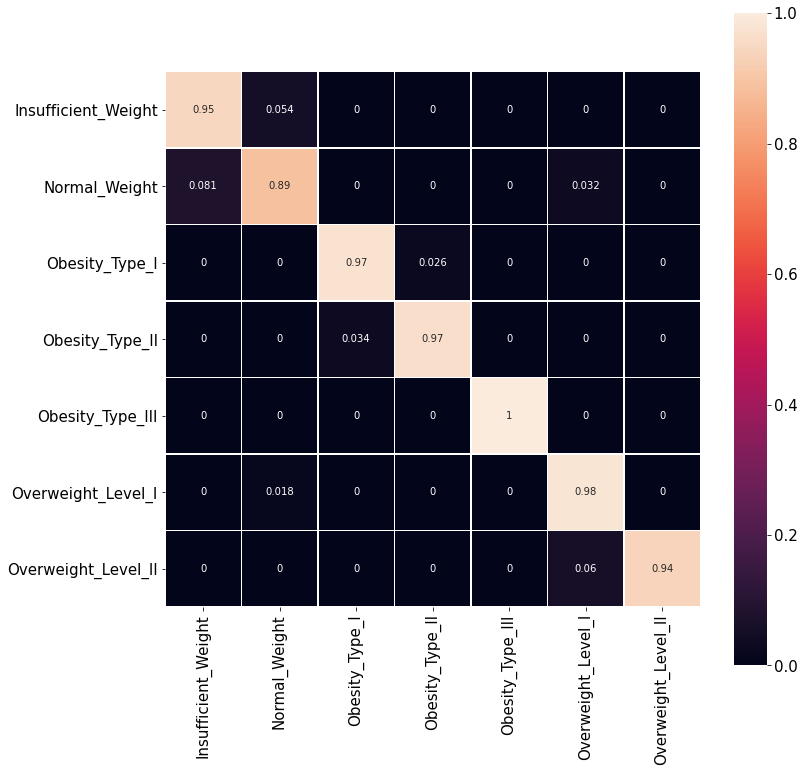

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## KNN

KNN é um modelo não paramétrico que busca calcular a classe do elemento de entrada $x$ baseado na classe dos elementos mais próximos de $x$. Esse modelo é, portanto, baseado em dois principais Hiperparâmetros: a função de distância e a quantidade (K) de vizinhos.

In [16]:
model = KNeighborsClassifier()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = knn_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__metric,param_model__n_neighbors,param_model__weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.019399,0.002729,0.030162,0.003084,manhattan,5,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.878698,0.863905,0.881657,0.842730,0.890208,0.871440,0.016675,1
1,0.021888,0.001985,0.025432,0.001464,manhattan,3,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.884615,0.846154,0.875740,0.851632,0.896142,0.870857,0.019143,2
5,0.018586,0.001620,0.025367,0.001577,manhattan,7,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.872781,0.846154,0.884615,0.830861,0.887240,0.864330,0.022174,3
0,0.022903,0.005110,0.046103,0.004911,manhattan,3,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.884615,0.828402,0.857988,0.851632,0.890208,0.862569,0.022618,4
7,0.019380,0.002960,0.030656,0.003587,manhattan,8,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.869822,0.840237,0.890533,0.833828,0.878338,0.862552,0.021946,5
2,0.021929,0.002122,0.048093,0.005281,manhattan,5,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.872781,0.849112,0.866864,0.821958,0.869436,0.856030,0.018902,6
9,0.018731,0.001289,0.029310,0.001990,manhattan,11,distance,"{'model__metric': 'manhattan', 'model__n_neigh...",0.855030,0.834320,0.857988,0.818991,0.872404,0.847746,0.018831,7
4,0.018067,0.003103,0.046709,0.005117,manhattan,7,uniform,"{'model__metric': 'manhattan', 'model__n_neigh...",0.849112,0.822485,0.863905,0.810089,0.866469,0.842412,0.022483,8
21,0.044876,0.011045,0.047553,0.013133,minkowski,3,distance,"{'model__metric': 'minkowski', 'model__n_neigh...",0.840237,0.807692,0.840237,0.804154,0.848665,0.828197,0.018479,9
11,0.035489,0.003513,0.039777,0.006663,euclidean,3,distance,"{'model__metric': 'euclidean', 'model__n_neigh...",0.840237,0.807692,0.840237,0.804154,0.848665,0.828197,0.018479,9


In [17]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

display(results)

show_metrics(results)

{'fit_time': array([0.03829169, 0.01970196, 0.01775432, 0.01995182, 0.02097583]),
 'score_time': array([0.01525807, 0.01548505, 0.02207065, 0.01666284, 0.02268982]),
 'test_accuracy': array([0.75294118, 0.74117647, 0.72941176, 0.82142857, 0.73809524]),
 'test_recall_macro': array([0.74434316, 0.72840909, 0.73376623, 0.81017316, 0.7461705 ]),
 'test_precision_macro': array([0.73504274, 0.77531744, 0.74878129, 0.84181097, 0.7541257 ])}

----------------------
Accuracy_Mean:  75.66%
Recall_Mean:    75.26%
Precision_Mean: 77.10%


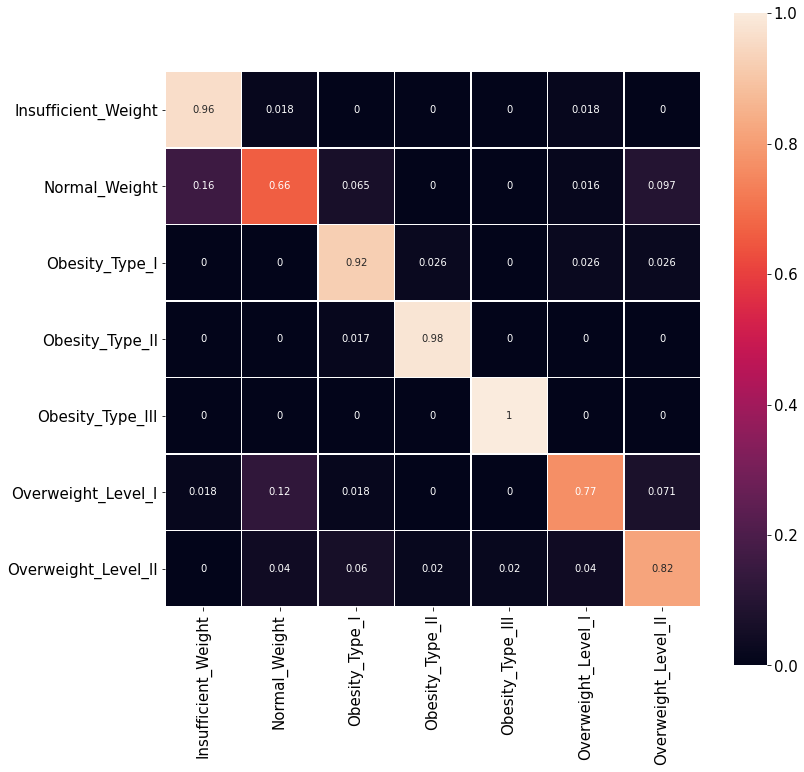

In [18]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);

## SVC (Support Vector Classification)

A idea básica por trás do SVC é mapear as nossas entradas para dimensões maiores, calcular a relação entre as entradas nas novas dimensões e encontrar um hiperplano que consegue separar os nossos dados na dimensão superior. Dessa forma, podemos facilmente detectar a que classe o elemento pertence.

Vamos tentar entender como chegar ao SVC a partir de ideias de algoritmos mais simples. A explicação vai ser voltada para classificação binária, mas ele pode ser extrapolado usando a ideia de one vs one.

### Margin, Maximal Margin Classifier

Maximal Margin Classifier se baseia na ideia de usar os pontos na fronteira das classes para calcular um ponto, linha ou hiperplano (depende da dimensão) que separa as duas classes. Mas especificamente, o hiperplano que separa as duas classes é chamado de margem e o Maximal Margin Classifier é quando nós usamos a maior margem para os nossos dados.

Esse modelo tem a desvantagem de ser fortemente influenciado por outliers e só conseguir resolver problemas linearmente separáveis.

### Soft Margin, Suport Vector Classifier

Soft Margin é a forma que temos de combater o primeiro problema do Maximal Margin Classifer, os outliers. Nesse caso, nós tentamos definir um hiperplano que seja menos sensível ao treino, ou seja, alguns dados podem acabar sendo classificados de forma errada, mas que tem maior potencial de generalização.

Quando usamos soft margin para classificar os dados estamos o modelo Suport Vector Classifier. Esse nome vem do fato dos dados da fronteira de dentro da classe usados para calcular a soft margin serem chamados de suport vectors.

### Kernel

Agora vamos resolver para o caso onde os dados não são linearmente separáveis usando Vector Machines. Nesse caso, o que nós vamos fazer é usar um função de kernel para aumentar as dimensões dos nossos dados e vamos um Suport Vector Classifer nessa dimensão superior.

### Vantagens
- Funciona para dados semi ou não estruturados
- Efetivo nos casos onde temos mais atributos do que observações

### Desvantagens
- Dificuldade de escolha de função de kernel
- Não é muito eficiente para datasets com muitas observações
- Pode ser difícil de tunar os hiperparâmetros C e gamma visto que o impacto é difícil de perceber

In [19]:
model = svm.SVC()

pipe = Pipeline([
        ('ord_enc', ordinal_encoder),
        ('scaler', StandardScaler()),
        ('model', model)
    ]
)

parameters = svc_parameters

grid = GridSearchCV(pipe, parameters)
grid.fit(x_train, y_train);
best_model = grid.best_estimator_
df = pd.DataFrame(grid.cv_results_)
df.sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__gamma,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
42,0.093236,0.005551,0.028908,0.001969,100,0.01,rbf,"{'model__C': 100, 'model__gamma': 0.01, 'model...",0.967456,0.952663,0.931953,0.925816,0.967359,0.949049,0.017431,1
45,0.094339,0.001506,0.036021,0.003072,100,0.001,rbf,"{'model__C': 100, 'model__gamma': 0.001, 'mode...",0.926036,0.931953,0.902367,0.913947,0.937685,0.922397,0.012735,2
30,0.096158,0.005192,0.036634,0.001598,10,0.01,rbf,"{'model__C': 10, 'model__gamma': 0.01, 'model_...",0.917160,0.928994,0.890533,0.899110,0.943620,0.915883,0.019323,3
27,0.134024,0.012195,0.035639,0.002219,10,0.1,rbf,"{'model__C': 10, 'model__gamma': 0.1, 'model__...",0.911243,0.893491,0.905325,0.878338,0.922849,0.902249,0.015252,4
39,0.150443,0.021335,0.041513,0.007861,100,0.1,rbf,"{'model__C': 100, 'model__gamma': 0.1, 'model_...",0.908284,0.890533,0.911243,0.881306,0.919881,0.902249,0.014171,4
28,0.079458,0.003104,0.019249,0.002709,10,0.1,poly,"{'model__C': 10, 'model__gamma': 0.1, 'model__...",0.881657,0.855030,0.902367,0.863501,0.884273,0.877366,0.016627,6
47,0.105324,0.006542,0.030473,0.002738,100,0.001,sigmoid,"{'model__C': 100, 'model__gamma': 0.001, 'mode...",0.887574,0.857988,0.875740,0.863501,0.890208,0.875002,0.012740,7
15,0.139693,0.005666,0.041085,0.002471,1,0.1,rbf,"{'model__C': 1, 'model__gamma': 0.1, 'model__k...",0.869822,0.878698,0.869822,0.845697,0.899110,0.872630,0.017200,8
1,0.081962,0.006279,0.019395,0.002208,0.1,1,poly,"{'model__C': 0.1, 'model__gamma': 1, 'model__k...",0.878698,0.857988,0.887574,0.836795,0.881306,0.868472,0.018695,9
25,0.084491,0.004065,0.017827,0.001492,10,1,poly,"{'model__C': 10, 'model__gamma': 1, 'model__ke...",0.878698,0.857988,0.887574,0.836795,0.881306,0.868472,0.018695,9


In [20]:
y_predict = best_model.predict(x_test)

results = cross_validate(best_model, 
                         x_test, 
                         y_test, cv=5, 
                         scoring=('accuracy', 'recall_macro', 'precision_macro'))

show_metrics(results)

----------------------
Accuracy_Mean:  87.47%
Recall_Mean:    86.79%
Precision_Mean: 87.00%


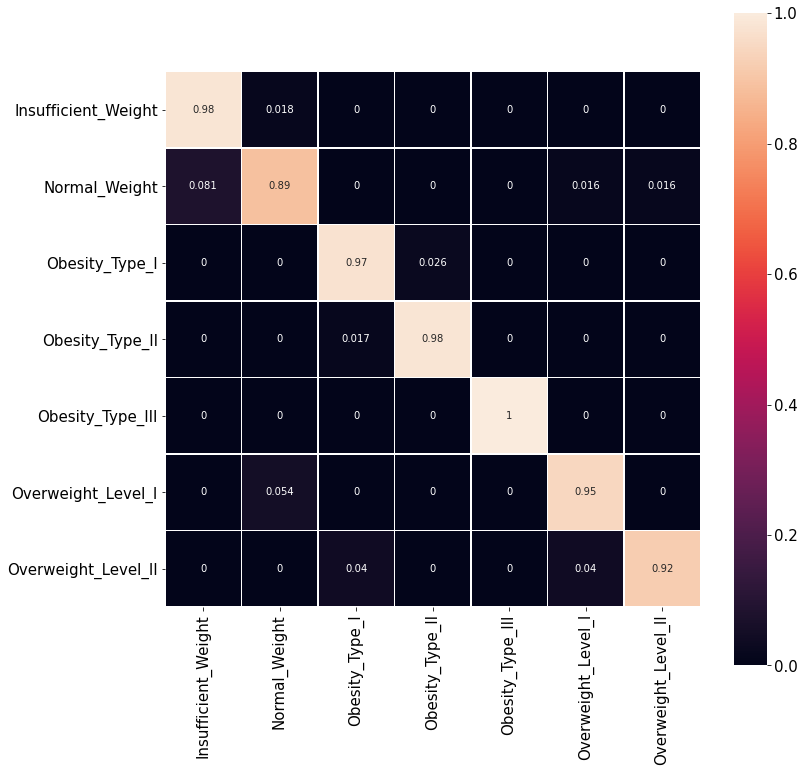

In [21]:
plt.figure(figsize=(12,12))
sns.heatmap(confusion_matrix(y_test, y_predict, normalize='true'), 
            annot=True, linewidths=0.5, square=True,
            xticklabels=obesity_level_encoder.classes_,
            yticklabels=obesity_level_encoder.classes_
);